# DOG & CAT - NEURAL NETWORK

The model is not efficient because flattening the image causes the pixels to lose their spatial relationships. We need to figure out how to make the model aware of the specific positions of the pixels in the image and their relationships with neighboring pixels.

## IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
import h5py

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder, label, image_size=(64, 64)):
    """
    Charge toutes les images d'un dossier et les associe à un label.
    """
    images = []
    labels = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            with Image.open(filepath) as img:
                img = img.resize(image_size)  # Redimensionner les images
                img = img.convert('RGB')  # Convertir en RGB pour uniformiser les canaux
                images.append(np.array(img))  # Convertir l'image en numpy array
                labels.append(label)  # Associer une étiquette (0 pour chat, 1 pour chien)
        except Exception as e:
            print(f"Erreur lors du chargement de {filepath}: {e}")
    return np.array(images), np.array(labels)

def load_dog_cat_data(dataset_path="datasets", image_size=(64, 64)):
    """
    Charge les données d'entraînement et de test pour les chiens et les chats.
    """
   # Chargement des données d'entraînement
    train_dogs, train_dogs_labels = load_images_from_folder(os.path.join(dataset_path, "train/dogs"), label=1, image_size=image_size)
    train_cats, train_cats_labels = load_images_from_folder(os.path.join(dataset_path, "train/cats"), label=0, image_size=image_size)

    print(f"Train Dogs: {train_dogs.shape}, Train Cats: {train_cats.shape}")

    # Concaténer les données
    X_train = np.concatenate((train_dogs, train_cats), axis=0)
    y_train = np.concatenate((train_dogs_labels, train_cats_labels), axis=0)

    # Vérifiez les dimensions
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

    # Concaténer les données d'entraînement
    X_train = np.concatenate((train_dogs, train_cats), axis=0)
    y_train = np.concatenate((train_dogs_labels, train_cats_labels), axis=0)

    # Chargement des données de test
    test_dogs, test_dogs_labels = load_images_from_folder(os.path.join(dataset_path, "test/dogs"), label=1, image_size=image_size)
    test_cats, test_cats_labels = load_images_from_folder(os.path.join(dataset_path, "test/cats"), label=0, image_size=image_size)

    # Concaténer les données de test
    X_test = np.concatenate((test_dogs, test_cats), axis=0)
    y_test = np.concatenate((test_dogs_labels, test_cats_labels), axis=0)

    # Normalisation des données (échelle de 0 à 1)
    X = X_train / 255.0
    X_test = X_test / 255.0

    y = y_train

    return X, y, X_test, y_test

# Exemple d'utilisation
X, y, X_test, y_test = load_dog_cat_data(dataset_path="datasets")

/Users/pr/Documents/_PERSO/CODE_FOLDER/Machine Learning/MODEL/Rneurone/NNvenv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Dogs: (12198, 64, 64, 3), Train Cats: (12198, 64, 64, 3)
X_train: (24396, 64, 64, 3), y_train: (24396,)


In [3]:
# Aplatir les données d'entrée
X_flattened = X.reshape(X.shape[0], -1).T  # (features, n_samples)
X_test_flattened = X_test.reshape(X_test.shape[0], -1).T

# Mettre à jour X et X_test
X = X_flattened
X_test = X_test_flattened

y = y.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print("Dimensions des données :")
print("X :", X.shape)
print("y :", y.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

Dimensions des données :
X : (12288, 24396)
y : (1, 24396)
X_test : (12288, 602)
y_test : (1, 602)


In [4]:
# Initialisation des parametres W et b et dimensions (Weight and biais)
def initialisation(dimensions):

    parametres = {}
    C = len(dimensions)

    for c in range (1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [5]:
#  Z = x1 * w1 + x2 * w2 + b /// if Z > 0 alors y = 1 else y = 0 
#  A = sigmoide de Z

def forward_propagation(X, parametres):

    activations = {'A0' : X}

    C = len(parametres) // 2

    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

In [6]:
# Descente de Gradient
def back_propagation(y, activations, parametres):

    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

    return gradients

In [7]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [8]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [9]:
def evaluate_model(X, y, parametres):
    """
    Évalue les performances du modèle sur un jeu de données donné.
    """
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    
    # Calcul de la perte
    loss = log_loss(y.flatten(), activations['A' + str(C)].flatten())
    
    # Prédictions
    y_pred = predict(X, parametres)
    
    # Calcul de l'exactitude
    accuracy = accuracy_score(y.flatten(), y_pred.flatten())
    
    return loss, accuracy


def neural_network(X, y, X_test, y_test, hidden_layers=(32, 32, 32), learning_rate=0.1, n_iter=1000):
    np.random.seed(0)
    # Initialisation des paramètres W, b
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])  # Entrée
    dimensions.append(y.shape[0])    # Sortie
    parametres = initialisation(dimensions)

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if i % 10 == 0:
            # Évaluation sur le train set
            C = len(parametres) // 2
            train_loss.append(log_loss(y.flatten(), activations['A' + str(C)].flatten()))
            y_pred = predict(X, parametres)
            train_accuracy.append(accuracy_score(y.flatten(), y_pred.flatten()))
            
            # Évaluation sur le test set
            loss, accuracy = evaluate_model(X_test, y_test, parametres)
            test_loss.append(loss)
            test_accuracy.append(accuracy)

    # Visualisation des résultats
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(train_accuracy, label='Train Accuracy')
    ax[1].plot(test_accuracy, label='Test Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

    # Afficher les performances finales sur le test set
    final_test_loss, final_test_accuracy = evaluate_model(X_test, y_test, parametres)
    print(f"Final Test Loss: {final_test_loss}")
    print(f"Final Test Accuracy: {final_test_accuracy}")

    print("\nSchema du Neural Network :")
    print("Parametre d'entrée :")
    print(parametres['W1'].shape[1])
    l = 1
    for i in hidden_layers:
        print('Neurone dans la Couche', l, ': ') 
        print(i)
        l += 1
    print("sortie :")
    print(parametres['b' + str(l)].shape[1])
        
    print("\nEntrainement :")
    print("Nombre d'itteration :", n_iter)
    print("taille des pas: ", learning_rate)
    print("\n \n")


    return parametres

100%|██████████| 1000/1000 [11:55<00:00,  1.40it/s]


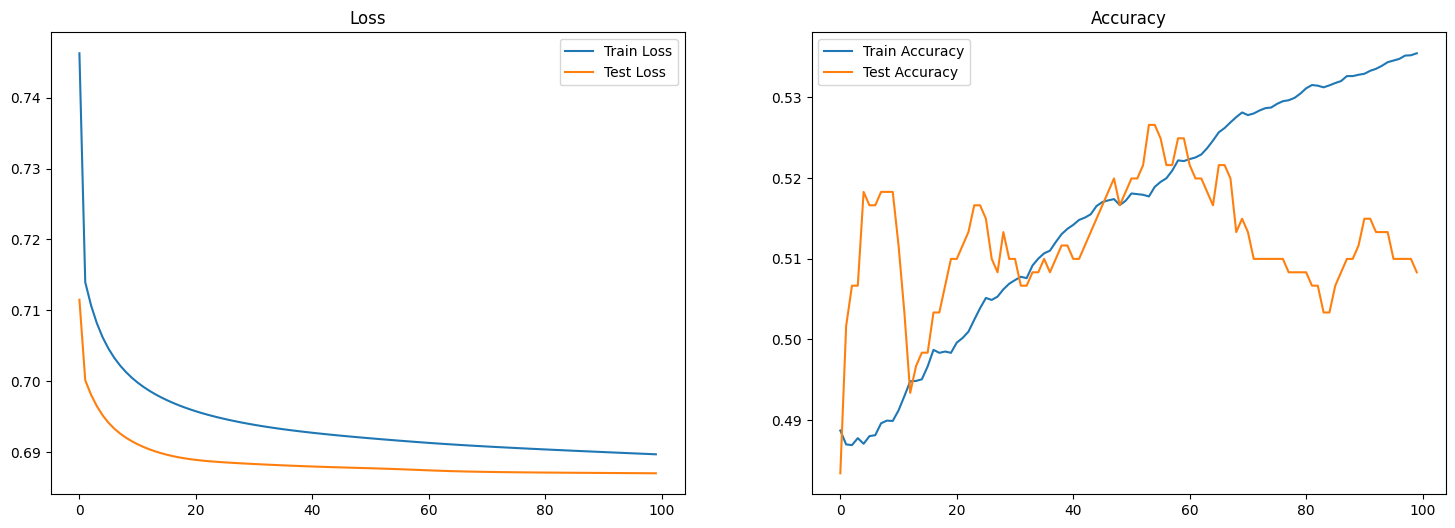

Final Test Loss: 0.6870125399653486
Final Test Accuracy: 0.5083056478405316

Schema du Neural Network :
Parametre d'entrée :
12288
Neurone dans la Couche 1 : 
32
Neurone dans la Couche 2 : 
32
Neurone dans la Couche 3 : 
32
sortie :
1

Entrainement :
Nombre d'itteration : 1000
taille des pas:  0.1

 



100%|██████████| 10000/10000 [2:16:51<00:00,  1.22it/s] 


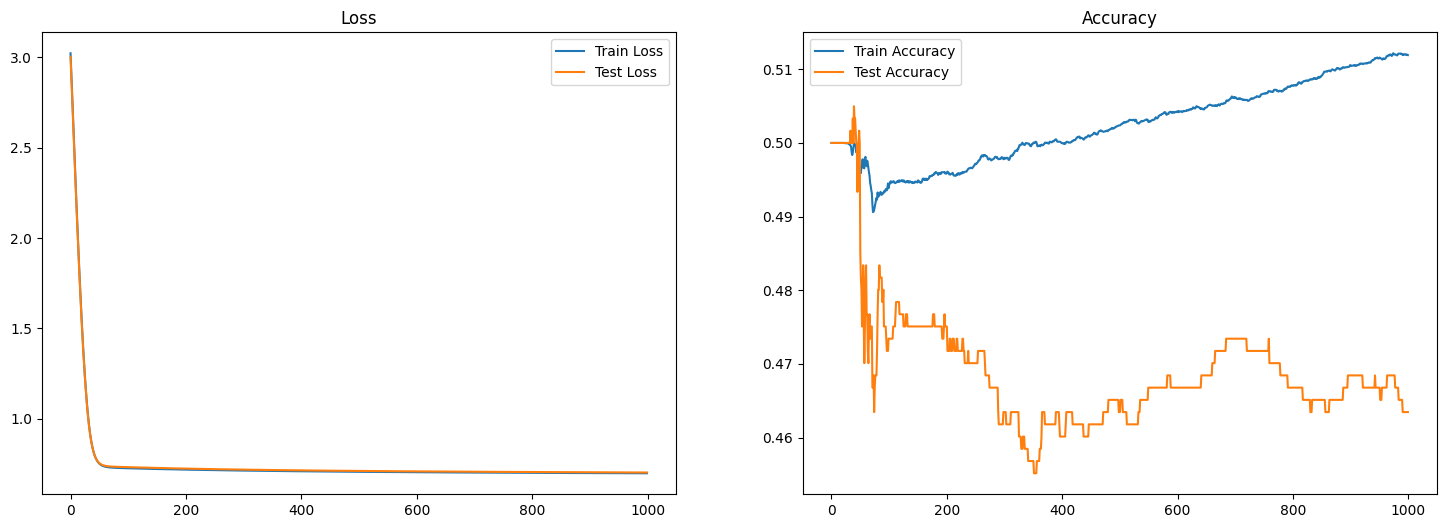

Final Test Loss: 0.7036927239183823
Final Test Accuracy: 0.4634551495016611

Schema du Neural Network :
Parametre d'entrée :
12288
Neurone dans la Couche 1 : 
32
Neurone dans la Couche 2 : 
32
Neurone dans la Couche 3 : 
32
Neurone dans la Couche 4 : 
32
sortie :
1

Entrainement :
Nombre d'itteration : 10000
taille des pas:  0.001

 



100%|██████████| 10000/10000 [4:46:56<00:00,  1.72s/it]    


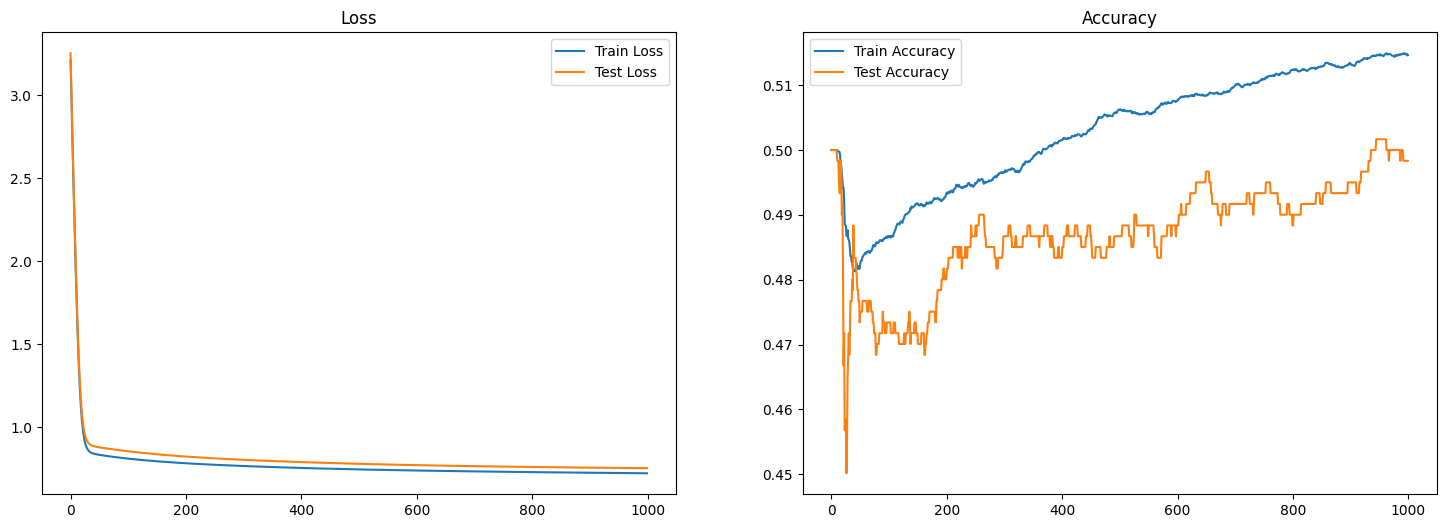

Final Test Loss: 0.7544998170911736
Final Test Accuracy: 0.4983388704318937

Schema du Neural Network :
Parametre d'entrée :
12288
Neurone dans la Couche 1 : 
64
Neurone dans la Couche 2 : 
64
Neurone dans la Couche 3 : 
64
sortie :
1

Entrainement :
Nombre d'itteration : 10000
taille des pas:  0.001

 



In [10]:
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter =1000)
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (32, 32, 32, 32), learning_rate = 0.001, n_iter =10000)
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (64, 64, 64), learning_rate = 0.001, n_iter =10000)